In [190]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

In [191]:
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [192]:
scene = load_scene("../models/wall/wall.xml")
scene.frequency = 2.14e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
for i,obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name}")
    print(f"{obj.position}")

tx0 = Transmitter("tx0", position=[10, 3, 2])
scene.add(tx0)
# tx1 = Transmitter("tx1", position=[5.0, 3, 1.0], look_at=[0,0,0])
# scene.add(tx1)

rx = Receiver("rx", position=[10, 7, 2 ])
scene.add(rx)

ris = RIS("ris", position=[14, 5, 2], look_at=(tx0.position + rx.position) / 2, num_rows=20, num_cols=20)
scene.add(ris)
print(f"RIS position: {ris.position}")

Cube : itu_concrete
[10.  5.  3.]
RIS position: [14.  5.  2.]


In [193]:
camera = Camera("cam", position=[3, 3.9, 2.5], look_at=[3, 2, 1.25])
scene.add(camera)
bird_cam = Camera("bird_cam", position=[10,5,20], look_at=[10,5,0])
scene.add(bird_cam)

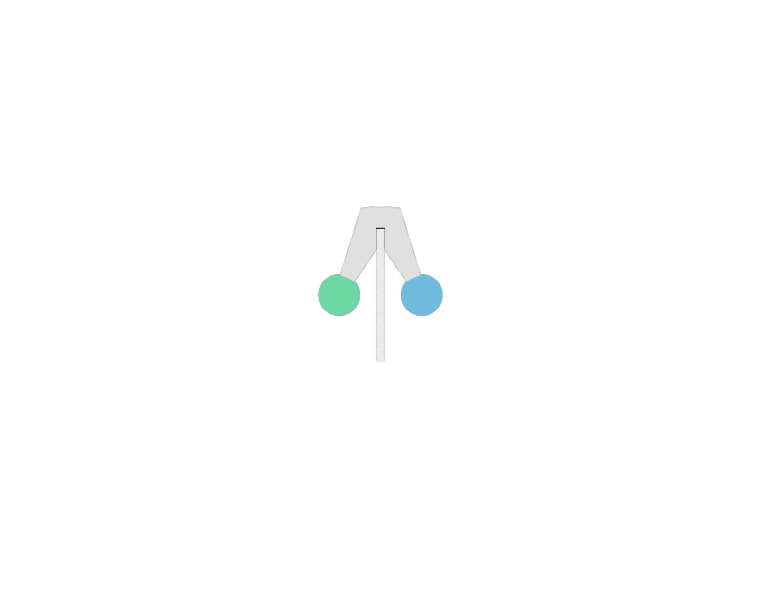

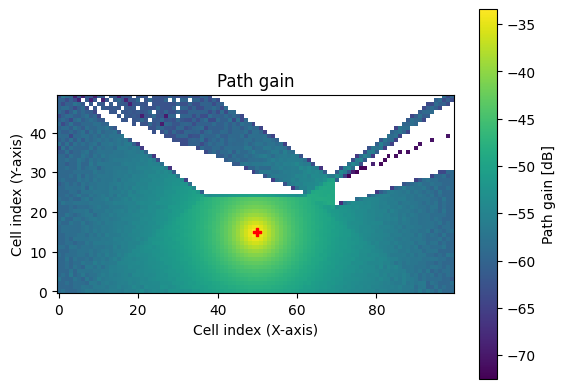

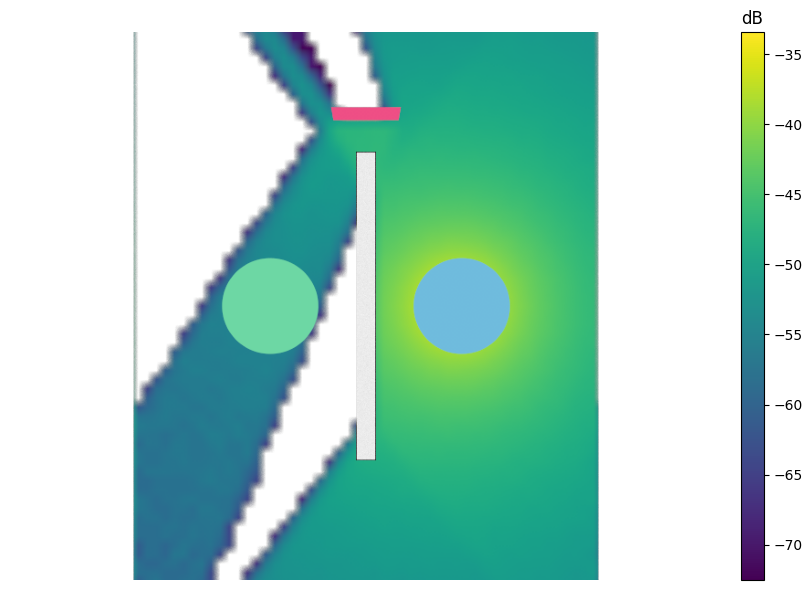

In [194]:
num_processed_csi_req = 0
paths = scene.compute_paths()
# scene.render_to_file(camera="cam", filename=f"renderings/scene{num_processed_csi_req}.png",
#                           resolution=[650,500], fov=90, paths=paths)
path_fig = scene.render(camera="bird_cam",
                          resolution=[650,500], fov=90, paths=paths)
cover_map = scene.coverage_map(max_depth=7,
                               num_samples=2e6,
                               cm_cell_size=[0.2,0.2],
                               cm_orientation=[0,0,0],
                               cm_center=[10,5,1.5],
                               cm_size=[20,10])
cover_map.show()
# scene.render_to_file(camera="bird_cam", filename=f"renderings/cm{num_processed_csi_req}.png",
#                           coverage_map=cover_map, resolution=[650,500], fov=90)
cm_fig = scene.render(camera="bird_cam",
                          coverage_map=cover_map, resolution=[780,600])